In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

np.random.seed(seed=1)

In [43]:
# 入力サンプルを用意する
num_of_samples_per_class = 20
blue_mean = [0]
red_left_mean = [-2]
red_right_mean = [2]
std_dev = 0.5

x_blue = np.random.randn(num_of_samples_per_class, 1) * std_dev + blue_mean
x_red_left = np.random.randn(num_of_samples_per_class // 2, 1) * std_dev + red_left_mean
x_red_right = np.random.randn(num_of_samples_per_class // 2, 1) * std_dev + red_right_mean

# xに入力のベクトル、tにクラスのベクトルが入る
x = np.vstack((x_blue, x_red_left, x_red_right))
t = np.vstack((np.ones((x_blue.shape[0], 1)),
               np.zeros((x_red_left.shape[0], 1)),
               np.zeros((x_red_right.shape[0], 1))))

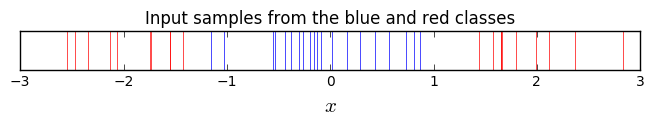

In [44]:
plt.figure(figsize=(8, 0.5))
plt.xlim(-3, 3)
plt.ylim(-1, 1)

plt.plot(x_blue, np.zeros_like(x_blue), 'b|', ms=30)
plt.plot(x_red_left, np.zeros_like(x_red_left), 'r|', ms=30)
plt.plot(x_red_right, np.zeros_like(x_red_right), 'r|', ms=30)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Input samples from the blue and red classes')
plt.xlabel('$x$', fontsize=15)
plt.show()

In [45]:
# RBF関数の定義
def rbf(z):
    return np.exp(-z**2)

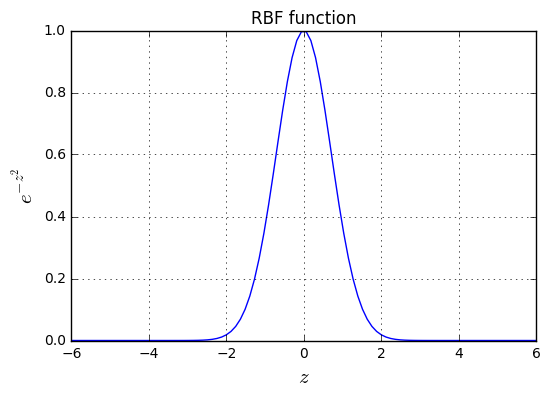

In [46]:
z = np.linspace(-6, 6, 100)
plt.plot(z, rbf(z), 'b-')
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$e^{-z^2}$', fontsize=15)
plt.title('RBF function')
plt.grid()
plt.show()

In [47]:
# ロジスティック関数
def logistic(z):
    return 1 / (1 + np.exp(-z))

# 隠れ層の値
def hidden_activations(x, wh):
    return rbf(x * wh)

# 出力層の値
def output_activations(h, wo):
    return logistic(h * wo - 1)

# モデルを定義
def nn(x, wh, wo):
    return output_activations(hidden_activations(x, wh), wo)

# モデルを使用してクラスを予測する関数
def nn_predict(x, wh, wo):
    return np.around(nn(x, wh, wo))

In [48]:
# コスト関数(クロスエントロピー)
def cost(y, t):
    return -np.sum(np.multiply(t, np.log(y)) + np.multiply((1 - t), np.log(1 - y)))

def cost_for_param(w, wh, wo, t):
    return cost(nn(w, wh, wo), t)

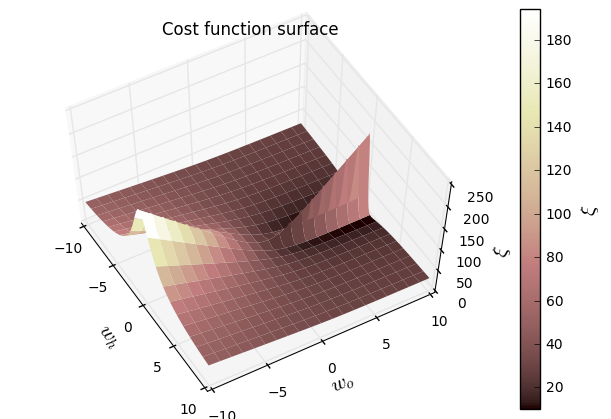

In [49]:
num_of_ws = 200
wsh = np.linspace(-10, 10, num=num_of_ws)
wso = np.linspace(-10, 10, num=num_of_ws)
ws_x, ws_y = np.meshgrid(wsh, wso)

cost_ws = np.zeros((num_of_ws, num_of_ws))
for i in range(num_of_ws):
    for j in range(num_of_ws):
        cost_ws[i, j] = cost(nn(x, ws_x[i, j], ws_y[i, j]), t)
        
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(ws_x, ws_y, cost_ws, linewidth=0, cmap=cm.pink)
ax.view_init(elev=60, azim=-30)
cbar = fig.colorbar(surf)
ax.set_xlabel('$w_h$', fontsize=15)
ax.set_ylabel('$w_o$', fontsize=15)
ax.set_zlabel('$\\xi$', fontsize=15)
cbar.ax.set_ylabel('$\\xi$', fontsize=15)
plt.title('Cost function surface')
plt.grid()
plt.show()

In [50]:
# エラーを出力層の入力で微分したもの
def gradient_output(y, t):
    return y - t

# エラーを出力層の重みで微分したもの
def gradient_weight_out(h, grad_output):
    return h * grad_output

# エラーを隠れ層への入力で微分したもの
def gradient_hidden(wo, grad_output):
    return wo * grad_output

# エラーを隠れ層の重みで微分したもの
def gradient_weight_hidden(x, zh, h, grad_hidden):
    return x * -2 * zh * h * grad_hidden

# バックプロパゲーションでの重みの更新
def backprop_update(x, t, wh, wo, learning_rate):
    # まずは順伝播
    zh = x * wh # 隠れ層への入力
    h = rbf(zh) # 隠れ層の出力 (=出力層への入力)
    y = output_activations(h, wo)  # 出力層の出力
    
    # 次に逆伝播
    # 出力層の重みwoの更新に必要なΔwoを求める
    grad_output = gradient_output(y, t)
    d_wo = learning_rate * gradient_weight_out(h, grad_output)
    
    # 同様に、隠れ層の重みwhの更新に必要なΔwhを求める
    grad_hidden = gradient_hidden(wo, grad_output)
    d_wh = leraning_rate * gradient_weight_hidden(x, zh, h, grad_hidden)

    # 重みを両方とも更新する
    return (wh - d_wh.sum(), wo - d_wo.sum())

In [66]:
# バックプロパゲーションを実行する

# 初期重み
wh = 2
wo = -5

# 学習率
learning_rate = 0.2

# 学習率は初期値から徐々に小さくしていく
num_of_iterations = 30
lr_update = learning_rate / num_of_iterations

# 各イテレーションでの重みを保存しておく
w_cost_iter = [(wh, wo, cost_for_param(x, wh, wo, t))] 

# イテレーションをまわす
for i in range(num_of_iterations):
    learning_rate -= lr_update
    wh, wo = backprop_update(x, t, wh, wo, learning_rate)
    w_cost_iter.append((wh, wo, cost_for_param(x, wh, wo, t)))
    
print('最終的なコストは{:.2f}で、その時の重みは wh: {:.2f} and wo: {:.2f} です。'.format(cost_for_param(x, wh, wo, t), wh, wo))

最終的なコストは13.53で、その時の重みは wh: 0.76 and wo: 2.92 です。


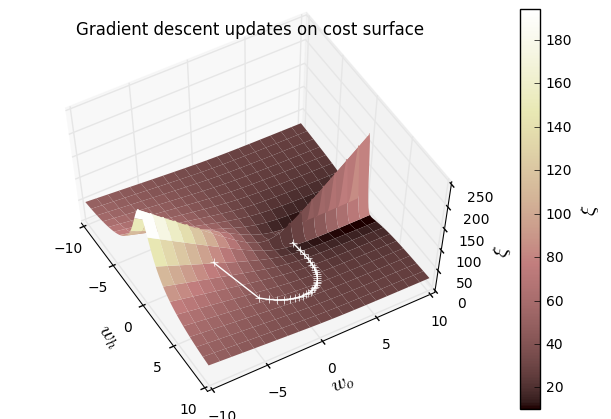

In [67]:
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(ws_x, ws_y, cost_ws, linewidth=0, cmap=cm.pink)
ax.view_init(elev=60, azim=-30)
cbar = fig.colorbar(surf)
cbar.ax.set_ylabel('$\\xi$', fontsize=15)

for i in range(1, len(w_cost_iter)):
    wh1, wo1, c1 = w_cost_iter[i-1]
    wh2, wo2, c2 = w_cost_iter[i]

    ax.plot([wh1], [wo1], [c1], 'w+')  # Plot the weight cost value
    ax.plot([wh1, wh2], [wo1, wo2], [c1, c2], 'w-')

wh1, wo1, c1 = w_cost_iter[len(w_cost_iter)-1]
ax.plot([wh1], [wo1], c1, 'w+')

ax.set_xlabel('$w_h$', fontsize=15)
ax.set_ylabel('$w_o$', fontsize=15)
ax.set_zlabel('$\\xi$', fontsize=15)
plt.title('Gradient descent updates on cost surface')
plt.grid()
plt.show()

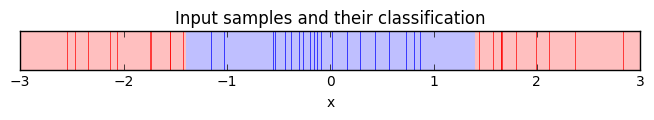

In [68]:
nb_of_xs = 100
xs = np.linspace(-3, 3, num=nb_of_xs)
ys = np.linspace(-1, 1, num=nb_of_xs)
xx, yy = np.meshgrid(xs, ys) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        classification_plane[i,j] = nn_predict(xx[i,j], wh, wo)
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.25),
        colorConverter.to_rgba('b', alpha=0.25)])

# Plot the classification plane with decision boundary and input samples
plt.figure(figsize=(8,0.5))
plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.xlim(-3,3)
plt.ylim(-1,1)
# Plot samples from both classes as lines on a 1D space
plt.plot(x_blue, np.zeros_like(x_blue), 'b|', ms = 30) 
plt.plot(x_red_left, np.zeros_like(x_red_left), 'r|', ms = 30) 
plt.plot(x_red_right, np.zeros_like(x_red_right), 'r|', ms = 30) 
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Input samples and their classification')
plt.xlabel('x')
plt.show()

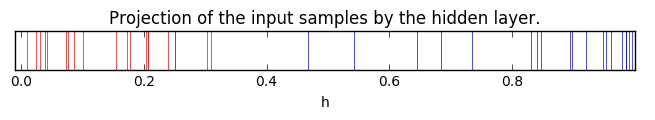

In [69]:
# 隠れ層の出力を可視化する
plt.figure(figsize=(8,0.5))
plt.xlim(-0.01,1)
plt.ylim(-1,1)

# 入力にhidden_activation関数を適用して隠れ層の出力を計算して、プロット
plt.plot(hidden_activations(x_blue, wh), np.zeros_like(x_blue), 'b|', ms = 30) 
plt.plot(hidden_activations(x_red_left, wh), np.zeros_like(x_red_left), 'r|', ms = 30) 
plt.plot(hidden_activations(x_red_right, wh), np.zeros_like(x_red_right), 'r|', ms = 30) 

plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Projection of the input samples by the hidden layer.')
plt.xlabel('h')
plt.show()